## Module 4 Final Project - Computer Vision

* Student name: Emily J. Cain
* Student pace: Full Time
* Scheduled project review date: Monday, February 25, 2019
* Instructor name: Rafael Carrasco
* Blog post URL: https://medium.com/@magicmilly

#### Here I will write about my awesome project and why it's important - maybe

## I. <a href='#section_1'>Load & Inspect Original Image Data</a>
## II. <a href='#section_2'>Preprocess Data</a>
* <a href='#resize_and_label'>Resize & Label Images</a>
* <a href='#save_images'>Save & Reload Images</a>
* <a href='#split_data'>Split Data into Features & Labels</a>
* <a href='#split_data'>Normalize Image Sizes</a>
* <a href='#reshape_features'>Reshape Images for Modeling</a>
* <a href='#one_hot'>One-hot Encode Labels</a>
* <a href='#train_test_split'>Split Data into Training and Test Sets</a>

## III. <a href='#section_3'>Convolutional Neural Networks</a>
* <a href='#model_1'>Model 1</a>
* <a href='#model_2'>Model 2</a>
* <a href='#model_3'>Model 3</a>
* <a href='#model_4'>Model 4</a>
* <a href='#model_5'>Model 5</a>
* <a href='#model_6'>Model 6</a>
* <a href='#model_7'>Model 7</a>

## IV. <a href='#section_4'>Final Model Evaluation</a> 
## V. <a href='#section_5'>Conclusions & Recommendations</a>

In [ ]:
# Notes to myself
# hyperlinks 
# everything you repeat should be a function - creating images, evaluating models, pandas df, and plots
# images! Show original images with labels before and after resizing
# can you show when your model got something wrong?
# before presentation, load an image set to show variables with consistent names
# add observations after each model & visual
# for each model, describe changes from previous model
# oh no did you check class balance?!!?!?! nooooo! you did not!!!!!
# collapse cells?
# what happens when you reload a model? can you get the history if you forgot to set this variable when calling fit()?
# can call .predict() on an imported model but must compile first
# model = load_model('my_model.h5')
# model.compile(usual compile arguments) - nevermind, load_model now compiles it for you
# y_pred = model.predict(X)
# you can make predictions, but if you didn't store history, you'll never get it back!!!!!!

In [98]:
import cv2
import datetime
import h5py
import numpy as np
import os
import pandas as pd
import warnings

from collections import Counter
from keras import regularizers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.models import load_model, Sequential
from keras.utils import to_categorical 
from matplotlib.pyplot import imshow
# from PIL import Image
# from scipy import ndimage
# from skimage.io import imread 
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
warnings.filterwarnings(action='ignore', category=FutureWarning)

## Custom Functions Used

In [22]:
def append_df(df, idx, results_list):
    
    """
    Manually append existing dataframe by specifying index and results from model.
    Returns updated dataframe with new results row.
    """
    
    df.loc[idx] = results_list
    return df

In [52]:
def print_metrics(model, X_train, y_train, X_test, y_test):
    
    """
    Print training and test metrics from model.
    Longer runtime for more computationally expensive models.
    """
    
    print(f'Training loss: {model.evaluate(X_train, y_train)[0]}')
    print(f'Training accuracy: {model.evaluate(X_train, y_train)[1]}')
    print(f'Test loss: {model.evaluate(X_test, y_test)[0]}')
    print(f'Test accuracy: {model.evaluate(X_test, y_test)[1]}')

In [59]:
def plot_acc_and_val(history):
    
    """
    Given a model's history with accuracy and loss values, returns a plot showing training accuracy, validation
    accuracy, training loss, and validation loss.
    """
    
    fig = plt.figure(figsize=(8,6))

    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.plot(epochs, loss, 'ro', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss & Accuracy')
    plt.legend(loc='best')
    plt.show()

In [111]:
def plot_confusion_matrix(y_preds, y_test):
    
    """
    Plot heatmap of confusion matrix to show true vs. predicted labels.
    
    Arguments: predicted y values from model.predict() and true y values
    
    Y values are reversed from one-hot encoding to integers representing the 
    index of class labels and used to produce confusion matrix. Confusion matrix 
    is converted to pandas DataFrame and then plotted as a Seaborn heatmap with 
    class labels.
    
    Returns: Confusion matrix heatmap figure
    
    """
    y_preds_reversed = [np.argmax(y, axis=None, out=None) for y in y_preds]
    y_test_reversed = [np.argmax(y, axis=None, out=None) for y in y_test]
    
    class_names = ['normal', 'cnv', 'dme', 'drusen']
    
    cm = confusion_matrix(y_test_reversed, y_preds_reversed)
    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    
    fig = plt.figure(figsize=(8,6))
    hm = sns.heatmap(data=df_cm, annot=True, cbar=True, cmap='YlGnBu', linewidths=0.5, fmt='d')
    hm.yaxis.set_ticklabels(hm.yaxis.get_ticklabels(), rotation=0)
    hm.xaxis.set_ticklabels(hm.xaxis.get_ticklabels(), rotation=45)
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.show()

## I. Load & Inspect Original Image Data<a id='section_1'></a>
<a href='#top'>Back to Top</a>

In [2]:
# calculate amount of images
cnv_imgs = len(os.listdir('Data/cnv'))
dme_imgs = len(os.listdir('Data/dme'))
drusen_imgs = len(os.listdir('Data/drusen'))
normal_imgs = len(os.listdir('Data/normal'))

total_imgs = cnv_imgs + dme_imgs + drusen_imgs + normal_imgs
print(f'There are {total_imgs} total images.')

There are 83606 total images.


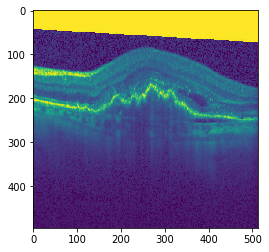

In [3]:
# inspect an original image
test_img = Image.open('Data/cnv/CNV-6294785-1.jpeg')
# test_img.show() - this opens image in new window
imshow(np.asarray(test_img)); # imshow for inline image

In [ ]:
# Show 4 labeled images?

In [ ]:
fig = plt.figure(figsize=(10,4))
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4)

fig.suptitle('Original Images with Labels')

original_cnv = Image.open('Data/cnv/CNV-6294785-1.jpeg')

ax1.set_title('CNV')
ax1.imshow(np.asarray(original_cnv))
ax2.set_title('Normal')
ax3.set_title('DME')
ax4.set_title('Drusen')

In [ ]:
# Show distribution of classes with histogram

## Preprocess Data<a id='section_2'></a>
* Resize
* Label
* Reshape for model input
* Split data into features (X) and labels (y)
* Normalize pixel values
* One-hot encode labels
* Train-test-split data into training and (holdout) test data

<a href='#top'>Back to Top</a>

### Resize and label images<a id='resize_and_label'></a>
Run cell below to create resized images as list `data`. If `data` already exists, the cell will not run again. Adjust `img_size` as needed.

In [2]:
img_classes = ['normal', 'cnv', 'dme', 'drusen']
img_size = 50
original_dir = 'Data'

# keep myself from re-creating this list if it already exists 
try:
    data = data
    print('Data already exists in this dimension')
    print(len(data))
except NameError: 
    data = None
    print('Re-loading images')
    
if data is None:
    data = []
    for img_class in img_classes:

        path = os.path.join(original_dir, img_class)
        # assign numeric value to class labels
        class_num = img_classes.index(img_class)

        for img in os.listdir(path):

            file = os.path.join(path, img)
            # if-else keeps .DS_store from throwing an error
            if file.endswith('.jpeg'):
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                # resize images to (40,40)
                resize_array = cv2.resize(img_array, (img_size, img_size))
                # create new data list of resized images with their class labels
                data.append([resize_array, class_num])
            else:
                print(file)

Re-loading images
Data/normal/.DS_Store


In [25]:
# Confirm image size
data[0][0].shape

(50, 50)

#### Save images as `.npy` file within `Data` folder so that they can be re-loaded later. Images will re-load automatically as a numpy array but must be assigned manually for immediate use. <a id='save_images'></a> 

In [26]:
np.save('Data/img_array_50', data)

In [8]:
# data = np.array(data)

In [9]:
# Check array dimensions
data.shape

(83605, 2)

#### Re-load images by assigning variable name and check shape to confirm.

In [49]:
db = np.load("./Data/img_array.npy")
db.shape

In [3]:
db.shape

(83605, 2)

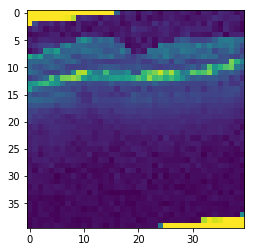

In [11]:
imshow(db[0][0]);

In [14]:
data[0][0].shape

(40, 40)

In [15]:
data[0].shape

(2,)

#### Split data into features (X) and labels (y) <a id='split_data'></a>
<a href='#top'>Back to Top</a>

In [32]:
X = []
y = []

for feature, label in data:
    # normalize image values by max value of 255
    X.append(feature/255)
    y.append(label)

In [33]:
len(X)

83605

In [34]:
len(y)

83605

In [35]:
# Confirm normalized pixel values
print(X[1])

[[1.         1.         1.         ... 0.07058824 0.10196078 0.01176471]
 [1.         0.63921569 0.65490196 ... 0.12941176 0.13333333 0.01960784]
 [0.16862745 0.09019608 0.1254902  ... 0.1372549  0.17254902 0.14117647]
 ...
 [0.07058824 0.05490196 0.0627451  ... 0.05882353 0.05882353 0.03137255]
 [0.05098039 0.07843137 0.0745098  ... 0.6        0.60784314 1.        ]
 [0.0627451  0.02352941 0.05490196 ... 1.         1.         1.        ]]


#### Reshape Images for Modeling <a id='reshape_features'></a>

In [36]:
img_size = 50
X = np.array(X).reshape(-1, img_size, img_size, 1)

In [40]:
X.shape

(83605, 50, 50, 1)

In [41]:
y.shape

(83605, 4)

#### One-hot encode labels <a id='one_hot'></a>
<a href='#top'>Back to Top</a>

In [38]:
y = to_categorical(y, num_classes=4)

In [ ]:
# Confirm 

#### Split Data into Training and (holdout) Test sets <a id='train_test_split'></a>

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=19, test_size=0.1)

In [ ]:
# Confirm by printing shapes

## III. Convolutional Neural Networks <a id='section_3'></a>
<a href='#top'>Back to Top</a>

### Model 1 <a id='model_1'></a>
* 3 convolutional layers
* 1 dense layer (not including output)

In [35]:
model = Sequential()
model.add(Conv2D(32, (3,3), input_shape=X.shape[1:], activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(32, (4,4), activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))

# Flatten() because Dense layers only like 1D data
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(4, activation='softmax'))

In [36]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [40]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 38, 38, 32)        320       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 19, 19, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 32)        16416     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 6, 6, 64)          18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 576)               0         
__________

In [37]:
start = datetime.datetime.now()

# batch_size default = 32
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2)
elapsed = datetime.datetime.now() - start
print(f'Time elapsed: {elapsed}')

Train on 53507 samples, validate on 13377 samples
Epoch 1/30
53507/53507 [==============================] - 58s 1ms/step - loss: 0.7637 - acc: 0.7091 - val_loss: 0.5662 - val_acc: 0.7889
Epoch 2/30
53507/53507 [==============================] - 57s 1ms/step - loss: 0.5258 - acc: 0.8058 - val_loss: 0.4756 - val_acc: 0.8238
Epoch 3/30
53507/53507 [==============================] - 54s 1ms/step - loss: 0.4472 - acc: 0.8366 - val_loss: 0.4626 - val_acc: 0.8343
Epoch 4/30
53507/53507 [==============================] - 56s 1ms/step - loss: 0.3993 - acc: 0.8549 - val_loss: 0.4218 - val_acc: 0.8440
Epoch 5/30
53507/53507 [==============================] - 55s 1ms/step - loss: 0.3654 - acc: 0.8672 - val_loss: 0.3893 - val_acc: 0.8562
Epoch 6/30
53507/53507 [==============================] - 55s 1ms/step - loss: 0.3366 - acc: 0.8783 - val_loss: 0.3836 - val_acc: 0.8626
Epoch 7/30
53507/53507 [==============================] - 56s 1ms/step - loss: 0.3126 - acc: 0.8862 - val_loss: 0.3889 - val_acc

#### Create pandas DataFrame to keep track of model details with results

In [23]:
columns = ['img_size', 'num_conv_layers', 'num_dense_layers', 'extras', 'epochs', 'acc', 'loss', 'val_acc', 'val_loss', 'time']
df = pd.DataFrame(columns=columns)
df

,img_size,num_conv_layers,num_dense_layers,extras,epochs,acc,loss,val_acc,val_loss,time


In [24]:
model_1_results = [40, 3, 1, 'None', 30, 0.97, 0.08, 0.86, 0.72, 28]
append_df(df, 0, model_1_results)

,img_size,num_conv_layers,num_dense_layers,extras,epochs,acc,loss,val_acc,val_loss,time
0,40,3,1,None,30,0.97,0.08,0.86,0.72,28


In [42]:
print_metrics(model, X_train, y_train, X_test, y_test)

66884/66884 [==============================] - 17s 253us/step
Training loss: 0.21424882945278623
66884/66884 [==============================] - 17s 253us/step
Training accuracy: 0.9441121942467556
16721/16721 [==============================] - 4s 259us/step
Test loss: 0.7160191144626018
16721/16721 [==============================] - 4s 259us/step
Test accuracy: 0.8564679146019738


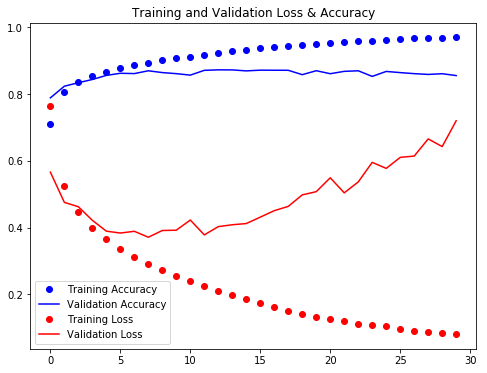

In [52]:
plot_acc_and_val(history)

In [ ]:
# Here I talk about Model 1 and how great it is

In [53]:
# model.save('Models/first_model_no_tuning.h5')

In [ ]:
# Ideas for optimizing model performance
# Reduce LR on plateau callback
# Early stopping
# Dropout? or regularizers?
# try padding - same for zeros padding 
# consider changing kernel size?
# use kernel regularizers to combat overfitting

#### Optimizing model with callbacks

In [45]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2,
                              patience=5, 
                              min_lr=0.001)

early_stoppage = EarlyStopping(monitor='val_loss', 
                               min_delta=0, 
                               patience=7, 
                               verbose=1, 
                               mode='auto', 
                               baseline=None, 
                               restore_best_weights=False)

In [44]:
X_train.shape

(66884, 40, 40, 1)

### Model 2 <a id='model_2'></a>
<a href='#top'>Back to Top</a>

In [47]:
model_2 = Sequential()
model_2.add(Conv2D(64, (2,2), 
                 input_shape=X.shape[1:], 
                 activation='relu', 
                 padding='same', 
                 kernel_regularizer=regularizers.l2(0.01)))
model_2.add(MaxPooling2D(2,2))

model_2.add(Conv2D(32, (2,2), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
model_2.add(MaxPooling2D(2,2))

model_2.add(Conv2D(64, (3,3), activation='relu'))
model_2.add(MaxPooling2D(2,2))

model_2.add(Flatten())
model_2.add(Dense(64, activation='relu'))
model_2.add(Dense(32, activation='relu'))
model_2.add(Dense(4, activation='softmax'))

In [48]:
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [51]:
start = datetime.datetime.now()

history = model_2.fit(X_train, y_train, 
                    callbacks=[reduce_lr, early_stoppage], 
                    epochs=20, 
                    batch_size=32,
                    validation_split=0.2)

elapsed = datetime.datetime.now() - start
print(f'Time elapsed: {elapsed}')

Train on 53507 samples, validate on 13377 samples
Epoch 1/20
53507/53507 [==============================] - 89s 2ms/step - loss: 0.9482 - acc: 0.6472 - val_loss: 0.8791 - val_acc: 0.6803
Epoch 2/20
53507/53507 [==============================] - 85s 2ms/step - loss: 0.7181 - acc: 0.7451 - val_loss: 0.6764 - val_acc: 0.7591
Epoch 3/20
53507/53507 [==============================] - 82s 2ms/step - loss: 0.6568 - acc: 0.7669 - val_loss: 0.6433 - val_acc: 0.7725
Epoch 4/20
53507/53507 [==============================] - 86s 2ms/step - loss: 0.6267 - acc: 0.7800 - val_loss: 0.6887 - val_acc: 0.7562
Epoch 5/20
53507/53507 [==============================] - 86s 2ms/step - loss: 0.5996 - acc: 0.7885 - val_loss: 0.6019 - val_acc: 0.7846
Epoch 6/20
53507/53507 [==============================] - 85s 2ms/step - loss: 0.5769 - acc: 0.7970 - val_loss: 0.5798 - val_acc: 0.7986
Epoch 7/20
53507/53507 [==============================] - 84s 2ms/step - loss: 0.5491 - acc: 0.8083 - val_loss: 0.5628 - val_acc

#### Compare model attributes and results

In [28]:
model_2_results = [40, 3, 2, 'callbacks', 20, 0.87, 0.40, 0.84, 0.49, 26]
append_df(df, 1, model_2_results)

,img_size,num_conv_layers,num_dense_layers,extras,epochs,acc,loss,val_acc,val_loss,time
0,40,3,1,None,30,0.97,0.08,0.86,0.72,28
1,40,3,2,callbacks,20,0.87,0.40,0.84,0.49,26


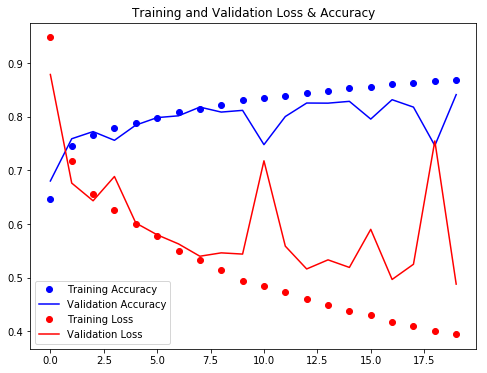

In [52]:
plot_acc_and_val(history)

In [ ]:
# plot indicates that more epochs could possibly improve the performance of this model - could try adding 
# 10 more epochs, possibly more layers?

In [53]:
model_2.save('Models/model_2_with_tunings.h5')

In [57]:
model_2.evaluate(X_test, y_test)

16721/16721 [==============================] - 6s 362us/step


[0.49538368569678876, 0.837928353570935]

### Model 2 Observations

#### Model 2 looks better with goodness of fit - will try adding a layer and more epochs

### Model 3 <a id='model_3'></a>
<a href='#top'>Back to Top</a>

In [54]:
model_3 = Sequential()
model_3.add(Conv2D(64, (2,2), 
                 input_shape=X.shape[1:], 
                 activation='relu', 
                 padding='same', 
                 kernel_regularizer=regularizers.l2(0.01)))
model_3.add(MaxPooling2D(2,2))

model_3.add(Conv2D(32, (2,2), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
model_3.add(MaxPooling2D(2,2))

model_3.add(Conv2D(64, (3,3), activation='relu'))
model_3.add(MaxPooling2D(2,2))

model_3.add(Conv2D(32, (2,2), activation='relu', padding='same'))
model_3.add(MaxPooling2D(2,2))

model_3.add(Flatten())
model_3.add(Dense(64, activation='relu'))
model_3.add(Dense(32, activation='relu'))
model_3.add(Dense(4, activation='softmax'))

In [55]:
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [58]:
start = datetime.datetime.now()

history_3 = model_3.fit(X_train, y_train, 
                    callbacks=[reduce_lr, early_stoppage], 
                    epochs=30, 
                    batch_size=32,
                    validation_split=0.2)

elapsed = datetime.datetime.now() - start
print(f'Time elapsed: {elapsed}')

Train on 53507 samples, validate on 13377 samples
Epoch 1/30
53507/53507 [==============================] - 74s 1ms/step - loss: 0.9905 - acc: 0.6196 - val_loss: 0.8608 - val_acc: 0.6910
Epoch 2/30
53507/53507 [==============================] - 71s 1ms/step - loss: 0.7326 - acc: 0.7385 - val_loss: 0.6678 - val_acc: 0.7627
Epoch 3/30
53507/53507 [==============================] - 71s 1ms/step - loss: 0.6667 - acc: 0.7631 - val_loss: 0.6428 - val_acc: 0.7694
Epoch 4/30
53507/53507 [==============================] - 70s 1ms/step - loss: 0.6340 - acc: 0.7755 - val_loss: 0.6019 - val_acc: 0.7846
Epoch 5/30
53507/53507 [==============================] - 71s 1ms/step - loss: 0.6029 - acc: 0.7872 - val_loss: 0.5898 - val_acc: 0.7920
Epoch 6/30
53507/53507 [==============================] - 71s 1ms/step - loss: 0.5831 - acc: 0.7964 - val_loss: 0.5733 - val_acc: 0.7969
Epoch 7/30
53507/53507 [==============================] - 73s 1ms/step - loss: 0.5669 - acc: 0.8003 - val_loss: 0.5719 - val_acc

#### Compare model attributes and results

In [30]:
model_3_results = [40, 4, 2, 'l2 reg', 30, 0.87, 0.40, 0.84, 0.48, 36]
append_df(df, 2, model_3_results)

,img_size,num_conv_layers,num_dense_layers,extras,epochs,acc,loss,val_acc,val_loss,time
0,40,3,1,None,30,0.97,0.08,0.86,0.72,28
1,40,3,2,callbacks,20,0.87,0.40,0.84,0.49,26
2,40,4,2,l2 reg,30,0.87,0.40,0.84,0.48,36


In [60]:
model_3.evaluate(X_test, y_test)

16721/16721 [==============================] - 6s 374us/step


[0.48898925440682584, 0.8396626996028709]

### Model 3 Observations

In [61]:
model_3.save('Models/model_3_extra_layer_epochs.h5')

### Model 4 <a id='model_4'></a>
* Increase filter size (using VGG models as example)
* Replace l2 regularizer with dropout layer

<a href='#top'>Back to Top</a>

In [9]:
model_4 = Sequential()
model_4.add(Conv2D(64, (3,4), 
                 input_shape=X.shape[1:], 
                 activation='relu', 
                 padding='same'))
model_4.add(MaxPooling2D(2,2))

model_4.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model_4.add(MaxPooling2D(2,2))

model_4.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model_4.add(MaxPooling2D(2,2))

model_4.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model_4.add(MaxPooling2D(2,2))

model_4.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model_4.add(MaxPooling2D(2,2))

model_4.add(Flatten())
model_4.add(Dense(64, activation='relu'))
model_4.add(Dropout(0.25))
model_4.add(Dense(32, activation='relu'))
model_4.add(Dropout(0.25))
model_4.add(Dense(4, activation='softmax'))

In [10]:
model_4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [13]:
start = datetime.datetime.now()

model_4.fit(X_train, y_train,
           batch_size=32,
           epochs=25,
           validation_split=0.2,
           callbacks=[reduce_lr, early_stoppage])

elapsed = datetime.datetime.now() - start
print(f'Time elapsed: {elapsed}')

Train on 53507 samples, validate on 13377 samples
Epoch 1/25
53507/53507 [==============================] - 251s 5ms/step - loss: 0.9948 - acc: 0.6023 - val_loss: 0.7263 - val_acc: 0.7160
Epoch 2/25
53507/53507 [==============================] - 261s 5ms/step - loss: 0.7204 - acc: 0.7293 - val_loss: 0.6581 - val_acc: 0.7621
Epoch 3/25
53507/53507 [==============================] - 252s 5ms/step - loss: 0.6417 - acc: 0.7752 - val_loss: 0.5745 - val_acc: 0.7940
Epoch 4/25
53507/53507 [==============================] - 241s 5ms/step - loss: 0.5732 - acc: 0.8014 - val_loss: 0.5112 - val_acc: 0.8124
Epoch 5/25
53507/53507 [==============================] - 246s 5ms/step - loss: 0.5338 - acc: 0.8131 - val_loss: 0.4936 - val_acc: 0.8168
Epoch 6/25
53507/53507 [==============================] - 257s 5ms/step - loss: 0.4977 - acc: 0.8245 - val_loss: 0.4707 - val_acc: 0.8230
Epoch 7/25
53507/53507 [==============================] - 259s 5ms/step - loss: 0.4689 - acc: 0.8345 - val_loss: 0.4430 - 

#### Compare model attributes and results

In [44]:
model_4_results = [40, 5, 2, 'dropout', 20, 0.90, 0.29, 0.86, 0.48, '1:29']
append_df(df, 3, model_4_results)

,img_size,num_conv_layers,num_dense_layers,extras,epochs,acc,loss,val_acc,val_loss,time
0,40,3,1,None,30,0.97,0.08,0.86,0.72,28
1,40,3,2,callbacks,20,0.87,0.40,0.84,0.49,26
2,40,4,2,l2 reg,30,0.87,0.40,0.84,0.48,36
3,40,5,2,dropout,20,0.90,0.29,0.86,0.48,1:29


In [ ]:
# Observations - Accuracy increased with more conv layers, larger conv and dense layers, and adding dropout.
# Training loss also decreased. Val_acc slightly increased. Val_loss stayed the same. The highest accuracy (but with
# the most overfitting) was observed in initial model - which was the only model with only 1 dense layer but no
# regularization, callbacks, or dropout. Model 1 also used the largest kernel size of (4,4) in one of its Conv layers.
# Will try using larger 50x50 images with an architecture similar to Model 1
# but with dropout and more nodes per layer, similar to Model 4. 

In [14]:
model_4.evaluate(X_test, y_test)

16721/16721 [==============================] - 14s 816us/step


[0.4644889997112417, 0.8591591412032537]

### Model 4 Observations

In [15]:
model_4.save('Models/model_4_larger_filters.h5')

### Model 5 <a id='model_5'></a>
* 1 dense layer with 1 dropout
* more nodes per layer
* larger kernel size in second Conv layer
* callbacks
* larger validation set (validation_split will stay the same, but training data overall is larger due to smaller holdout set)

<a href='#top'>Back to Top</a>

In [46]:
model_5 = Sequential()
model_5.add(Conv2D(64, (3,3), 
                  input_shape=X.shape[1:], 
                  activation='relu'))
model_5.add(MaxPooling2D(2,2))

model_5.add(Conv2D(64, (4,4), activation='relu'))
model_5.add(MaxPooling2D(2,2))

model_5.add(Conv2D(128, (3,3), activation='relu'))
model_5.add(MaxPooling2D(2,2))

model_5.add(Flatten())
model_5.add(Dense(64, activation='relu'))
model_5.add(Dropout(0.5))
model_5.add(Dense(4, activation='softmax'))

In [51]:
model_5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 64)        65600     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
__________

In [47]:
model_5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [48]:
start = datetime.datetime.now()

history_5 = model_5.fit(X_train, y_train,
                       validation_split=0.2,
                       callbacks=[reduce_lr, early_stoppage],
                       batch_size=32,
                       epochs=25)

elapsed = datetime.datetime.now() - start
print(f'Total time elapsed: {elapsed}')

Train on 60195 samples, validate on 15049 samples
Epoch 1/25
60195/60195 [==============================] - 243s 4ms/step - loss: 0.7405 - acc: 0.7226 - val_loss: 0.5719 - val_acc: 0.7893
Epoch 2/25
60195/60195 [==============================] - 225s 4ms/step - loss: 0.5030 - acc: 0.8220 - val_loss: 0.4288 - val_acc: 0.8441
Epoch 3/25
60195/60195 [==============================] - 224s 4ms/step - loss: 0.4182 - acc: 0.8539 - val_loss: 0.3703 - val_acc: 0.8672
Epoch 4/25
60195/60195 [==============================] - 224s 4ms/step - loss: 0.3687 - acc: 0.8731 - val_loss: 0.3515 - val_acc: 0.8786
Epoch 5/25
60195/60195 [==============================] - 225s 4ms/step - loss: 0.3357 - acc: 0.8841 - val_loss: 0.3412 - val_acc: 0.8811
Epoch 6/25
60195/60195 [==============================] - 226s 4ms/step - loss: 0.3090 - acc: 0.8926 - val_loss: 0.3128 - val_acc: 0.8921
Epoch 7/25
60195/60195 [==============================] - 231s 4ms/step - loss: 0.2874 - acc: 0.8995 - val_loss: 0.3197 - 

#### Compare model attributes and results

In [61]:
model_5_results = [50, 3, 1, 'increase img size', 13, 0.93, 0.2, 0.90, 0.33, 50]
append_df(df, 4, model_5_results)

,img_size,num_conv_layers,num_dense_layers,extras,epochs,acc,loss,val_acc,val_loss,time
0,40,3,1,None,30,0.97,0.08,0.86,0.72,28
1,40,3,2,callbacks,20,0.87,0.40,0.84,0.49,26
2,40,4,2,l2 reg,30,0.87,0.40,0.84,0.48,36
3,40,5,2,dropout,20,0.90,0.29,0.86,0.48,1:29
4,50,3,1,increase img size,13,0.93,0.20,0.90,0.33,50


In [53]:
print_metrics(model_5, X_train, y_train, X_test, y_test)

75244/75244 [==============================] - 75s 995us/step
Training loss: 0.18105564022579423
75244/75244 [==============================] - 76s 1ms/step
Training accuracy: 0.9374568071904527
8361/8361 [==============================] - 9s 1ms/step
Test loss: 0.33459371699056134
8361/8361 [==============================] - 8s 993us/step
Test accuracy: 0.8986963282046656


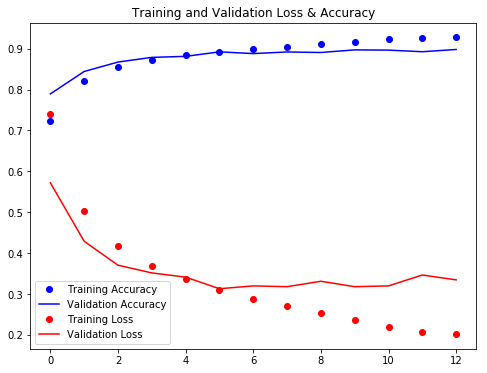

In [60]:
plot_acc_and_val(history_5)

### Observations on Model 5
Model 5 performs better than the previous models (in all 4 areas), though it stopped after only 13 epochs. The plot shows that val_loss did reach a plateau, but perhaps a few more epochs would have given the model a slight improvement. Will adjust callbacks to decrease patience on learning rate and increase patience on early stopping. Will keep increased image size and larger training set, add another large convolutional layer, and add another dense layer with dropout. 

In [69]:
model_5.save('Models/model_5_more_train_data.h5')

### Model 6 <a id='model_6'></a>
* add 1 convolutional layer
* add 1 dense layer with dropout
* adjust patience on callbacks

<a href='#top'>Back to Top</a>

#### Reduce patience for reducing Learning Rate and increase patience for Early Stopping

In [62]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2,
                              patience=3, 
                              min_lr=0.001,
                              verbose=1)

early_stoppage = EarlyStopping(monitor='val_loss', 
                               min_delta=0, 
                               patience=10, 
                               verbose=1, 
                               mode='auto', 
                               baseline=None, 
                               restore_best_weights=False)

In [65]:
model_6 = Sequential()
model_6.add(Conv2D(64, (3,3), 
                  input_shape=X.shape[1:], 
                  activation='relu',
                  padding='same'))
model_6.add(MaxPooling2D(2,2))

model_6.add(Conv2D(64, (4,4), activation='relu', padding='same'))
model_6.add(MaxPooling2D(2,2))

model_6.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model_6.add(MaxPooling2D(2,2))

model_6.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model_6.add(MaxPooling2D(2,2))

model_6.add(Flatten())
model_6.add(Dense(64, activation='relu'))
model_6.add(Dropout(0.3))
model_6.add(Dense(64, activation='relu'))
model_6.add(Dropout(0.3))
model_6.add(Dense(4, activation='softmax'))

In [67]:
model_6.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 50, 50, 64)        640       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 25, 25, 64)        65600     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 6, 6, 256)         295168    
__________

In [66]:
model_6.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [68]:
start = datetime.datetime.now()

history_6 = model_6.fit(X_train, y_train,
                       callbacks=[reduce_lr, early_stoppage],
                       validation_split=0.2,
                       batch_size=32,
                       epochs=30)

elapsed = datetime.datetime.now() - start
print(f'Total time elapsed: {elapsed}')

Train on 60195 samples, validate on 15049 samples
Epoch 1/30
60195/60195 [==============================] - 363s 6ms/step - loss: 0.7665 - acc: 0.7051 - val_loss: 0.5581 - val_acc: 0.8012
Epoch 2/30
60195/60195 [==============================] - 350s 6ms/step - loss: 0.4739 - acc: 0.8340 - val_loss: 0.4018 - val_acc: 0.8573
Epoch 3/30
60195/60195 [==============================] - 348s 6ms/step - loss: 0.3892 - acc: 0.8651 - val_loss: 0.3329 - val_acc: 0.8823
Epoch 4/30
60195/60195 [==============================] - 332s 6ms/step - loss: 0.3392 - acc: 0.8852 - val_loss: 0.3231 - val_acc: 0.8874
Epoch 5/30
60195/60195 [==============================] - 359s 6ms/step - loss: 0.3069 - acc: 0.8945 - val_loss: 0.3274 - val_acc: 0.8833
Epoch 6/30
60195/60195 [==============================] - 354s 6ms/step - loss: 0.2802 - acc: 0.9047 - val_loss: 0.3084 - val_acc: 0.8949
Epoch 7/30
60195/60195 [==============================] - 374s 6ms/step - loss: 0.2507 - acc: 0.9142 - val_loss: 0.3468 - 

In [74]:
model_6_results = [50, 4, 2, 'more layers', 19, 0.96, 0.1, 0.90, 0.4, '1:51']
append_df(df, 5, model_6_results)

,img_size,num_conv_layers,num_dense_layers,extras,epochs,acc,loss,val_acc,val_loss,time
0,40,3,1,None,30,0.97,0.08,0.86,0.72,28
1,40,3,2,callbacks,20,0.87,0.40,0.84,0.49,26
2,40,4,2,l2 reg,30,0.87,0.40,0.84,0.48,36
3,40,5,2,dropout,20,0.90,0.29,0.86,0.48,1:29
4,50,3,1,increase img size,13,0.93,0.20,0.90,0.33,50
5,50,4,2,more layers,19,0.96,0.10,0.90,0.40,1:51


#### Compare model attributes and results

In [71]:
print_metrics(model_6, X_train, y_train, X_test, y_test)

75244/75244 [==============================] - 103s 1ms/step
Training loss: 0.138779150518756
75244/75244 [==============================] - 100s 1ms/step
Training accuracy: 0.9592259847929613
8361/8361 [==============================] - 11s 1ms/step
Test loss: 0.41002111081486187
8361/8361 [==============================] - 11s 1ms/step
Test accuracy: 0.9010883865708897


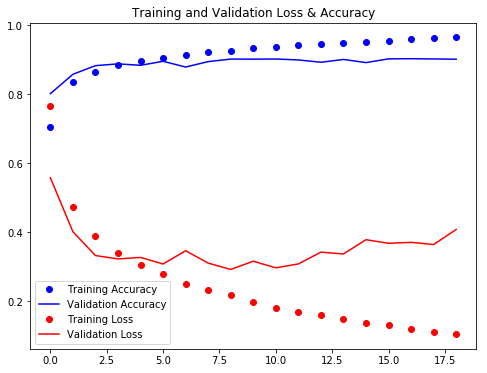

In [72]:
plot_acc_and_val(history_6)

### Model 6 Observations
Increasing layers improved training accuracy and reduced training loss, but there was no improvement in validation accuracy or loss. Validation loss actually increased, indicating overfitting. Reducing the dropout percentage and adjusting the callbacks to continue training when it probably should've stopped most likely led to the overfitting. Keeping the basic architecture of the model the same, while reverting back to a 0.5 dropout and the original callback parameters would show if these attributes were responsible for the overfitting. 

In [70]:
model_6.save('Models/model_6_moar_layerz.h5')

#### Reverse one-hot encoding of y-values

In [75]:
y_pred = model_6.predict(X_test)

In [81]:
# just to check that I am using this correctly
sample_y_preds = y_pred[:3]
sample_y_test = y_test[:3]
print(sample_y_preds)
print(sample_y_test)

[[7.2729070e-18 1.0000000e+00 2.9092839e-12 3.2552062e-08]
 [2.5271588e-06 9.9717772e-01 3.2787386e-05 2.7870035e-03]
 [5.2496420e-25 1.0000000e+00 9.1013899e-23 8.4577748e-15]]
[[0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]]


In [83]:
y_pred_reverse = [np.argmax(y, axis=None, out=None) for y in sample_y_preds]
y_test_reverse = [np.argmax(y, axis=None, out=None) for y in sample_y_test]

In [84]:
print(y_pred_reverse)
print(y_test_reverse)

[1, 1, 1]
[1, 3, 1]


In [85]:
y_preds_reversed = [np.argmax(y, axis=None, out=None) for y in y_pred]
y_true_reversed = [np.argmax(y, axis=None, out=None) for y in y_test]

#### Confusion Matrix for Model 6

In [94]:
cm = confusion_matrix(y_true_reversed, y_preds_reversed)
cm

array([[2507,   29,  105,   76],
       [  24, 3535,   31,   70],
       [  75,   79,  957,   16],
       [ 169,  132,   21,  535]])

In [96]:
class_names = ['normal', 'cnv', 'dme', 'drusen']

In [97]:
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
df_cm

,normal,cnv,dme,drusen
normal,2507,29,105,76
cnv,24,3535,31,70
dme,75,79,957,16
drusen,169,132,21,535


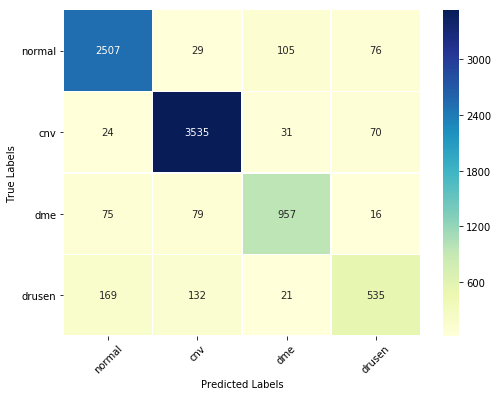

In [100]:
fig = plt.figure(figsize=(8,6))
hm = sns.heatmap(data=df_cm, annot=True, cbar=True, cmap='YlGnBu', linewidths=0.5, fmt='d')
hm.yaxis.set_ticklabels(hm.yaxis.get_ticklabels(), rotation=0)
hm.xaxis.set_ticklabels(hm.xaxis.get_ticklabels(), rotation=45)
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

#### Confusion Matrix Observations
The confusion matrix reflects the number of samples in each class. The model is able to predict CNV images the best because that class had the most data. Conversely, the model performed poorly on Drusen images because that class had the smallest amount of data samples, reducing its ability to learn how to predict this class.  

In [ ]:
# all of this can be turned into a function. . . when I'm training my next model

### Model 7 <a id='model_7'></a>
* Goal: reduce overfitting seen in the previous model
* Revert patience values on callbacks
* Increase dropout values to 0.5
* Decrease epochs

<a href='#top'>Back to Top</a>

In [101]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2,
                              patience=5, 
                              min_lr=0.001,
                              verbose=1)

early_stoppage = EarlyStopping(monitor='val_loss', 
                               min_delta=0, 
                               patience=7, 
                               verbose=1)

In [102]:
model_7 = Sequential()
model_7.add(Conv2D(64, (3,3), 
                  input_shape=X.shape[1:], 
                  activation='relu',
                  padding='same'))
model_7.add(MaxPooling2D(2,2))

model_7.add(Conv2D(64, (4,4), activation='relu', padding='same'))
model_7.add(MaxPooling2D(2,2))

model_7.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model_7.add(MaxPooling2D(2,2))

model_7.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model_7.add(MaxPooling2D(2,2))

model_7.add(Flatten())
model_7.add(Dense(64, activation='relu'))
model_7.add(Dropout(0.5))
model_7.add(Dense(64, activation='relu'))
model_7.add(Dropout(0.5))
model_7.add(Dense(4, activation='softmax'))

In [103]:
model_7.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [104]:
start = datetime.datetime.now()

history_7 = model_7.fit(X_train, y_train,
                     callbacks=[reduce_lr, early_stoppage],
                     batch_size=32,
                     epochs=20,
                     validation_split=0.2)

elapsed = datetime.datetime.now() - start
print(f'Total time elapsed: {elapsed}')

Train on 60195 samples, validate on 15049 samples
Epoch 1/20
60195/60195 [==============================] - 342s 6ms/step - loss: 0.7953 - acc: 0.6972 - val_loss: 0.6687 - val_acc: 0.7545
Epoch 2/20
60195/60195 [==============================] - 350s 6ms/step - loss: 0.5942 - acc: 0.7925 - val_loss: 0.4683 - val_acc: 0.8239
Epoch 3/20
60195/60195 [==============================] - 341s 6ms/step - loss: 0.4759 - acc: 0.8380 - val_loss: 0.3847 - val_acc: 0.8634
Epoch 4/20
60195/60195 [==============================] - 337s 6ms/step - loss: 0.4119 - acc: 0.8601 - val_loss: 0.3435 - val_acc: 0.8819
Epoch 5/20
60195/60195 [==============================] - 342s 6ms/step - loss: 0.3725 - acc: 0.8760 - val_loss: 0.3305 - val_acc: 0.8858
Epoch 6/20
60195/60195 [==============================] - 352s 6ms/step - loss: 0.3452 - acc: 0.8854 - val_loss: 0.3522 - val_acc: 0.8772
Epoch 7/20
60195/60195 [==============================] - 343s 6ms/step - loss: 0.3218 - acc: 0.8931 - val_loss: 0.3264 - 

In [106]:
print_metrics(model_7, X_train, y_train, X_test, y_test)

75244/75244 [==============================] - 113s 1ms/step
Training loss: 0.16527045492870432
75244/75244 [==============================] - 112s 1ms/step
Training accuracy: 0.9427462654797935
8361/8361 [==============================] - 13s 2ms/step
Test loss: 0.36724562323303006
8361/8361 [==============================] - 12s 1ms/step
Test accuracy: 0.8936730056355949


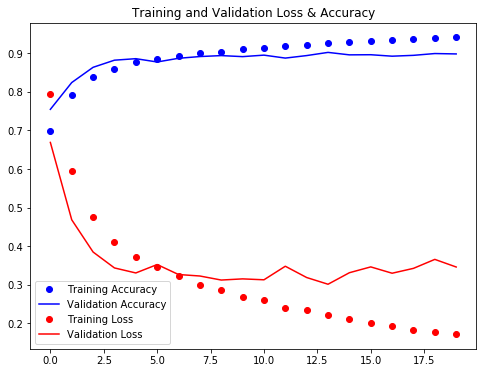

In [109]:
plot_acc_and_val(history_7)

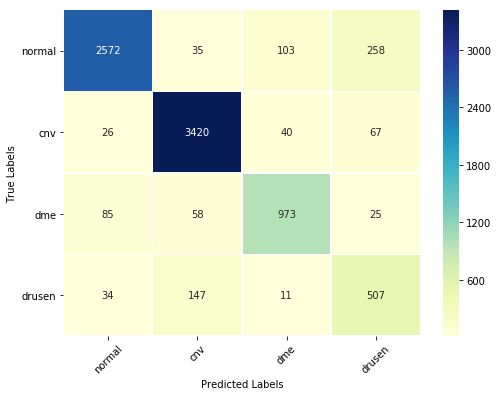

In [112]:
y_preds = model_7.predict(X_test)

# run confusion matrix function first
plot_confusion_matrix(y_test, y_preds)

In [105]:
model_7.save('Models/model_7_more_dropout.h5')

In [114]:
model_7_results = [50, 4, 2, 'more dropout', 20, 0.94, 0.17, 0.90, 0.35, '1:55']
append_df(df, 6, model_7_results)

,img_size,num_conv_layers,num_dense_layers,extras,epochs,acc,loss,val_acc,val_loss,time
0,40,3,1,None,30,0.97,0.08,0.86,0.72,28
1,40,3,2,callbacks,20,0.87,0.40,0.84,0.49,26
2,40,4,2,l2 reg,30,0.87,0.40,0.84,0.48,36
3,40,5,2,dropout,20,0.90,0.29,0.86,0.48,1:29
4,50,3,1,increase img size,13,0.93,0.20,0.90,0.33,50
5,50,4,2,more layers,19,0.96,0.10,0.90,0.40,1:51
6,50,4,2,more dropout,20,0.94,0.17,0.90,0.35,1:55


In [ ]:
# Model 7 vs. Model 6 Knock Out Round
# Model 7 shows a better fit when comparing training and validation data. The testing scores were slightly better
# but because the test set is so small, the difference could be random. The increased dropout probably helped the
# fit and also allowed the model to train for more epochs before early stopping. Training for more than 20 epochs
# would probably increase the training accuracy but might also lead to more overfitting. Model 6 tested slightly
# better on (the smallest class) Drusen samples, but worse on DME samples - not much of a difference. Some 
# parameters I did not tune like learning rate, and I could have. I think Model 7 is still pretty good for the time 
# I have spent training. That'll do, pig. That'll do.  

In [119]:
# this doesn't work 
# incorrect_indices = [i for i,v in enumerate(y_preds) if y_preds[i] != y_test[i]]
# subset_of_wrongly_predicted = [x_test[i] for i in indices]

## IV. Final Model Evaluation <a id='section_4'></a>
<a href='#top'>Back to Top</a>

## V. Conclusions & Recommendations <a id='section_5'></a>
<a href='#top'>Back to Top</a>

pretty print confusion matrix function originally created by [shaypal5](https://gist.github.com/shaypal5)

## Stuff that doesn't need to be Up There

In [ ]:
# I hope this is still correct
img_classes = ['normal', 'cnv', 'dme', 'drusen']

In [89]:
cnv_imgs = len(os.listdir('Data/cnv'))
dme_imgs = len(os.listdir('Data/dme'))
drusen_imgs = len(os.listdir('Data/drusen'))
normal_imgs = len(os.listdir('Data/normal'))

print(f'Number of cnv images: {cnv_imgs}')
print(f'Number of dme images: {dme_imgs}')
print(f'Number of drusen images: {drusen_imgs}')
print(f'Number of normal images: {normal_imgs}')

Number of cnv images: 37216
Number of dme images: 11422
Number of drusen images: 8620
Number of normal images: 26348


In [88]:
y_train_reversed = [np.argmax(y, axis=None, out=None) for y in y_train]

In [92]:
print(Counter(y_train_reversed))
print(Counter(y_true_reversed))

Counter({1: 33556, 0: 23630, 2: 10295, 3: 7763})
Counter({1: 3660, 0: 2717, 2: 1127, 3: 857})


In [ ]:
# 0 = normal
# 1 = cnv
# 2 = dme
# 3 = drusen
# I know I'm a Neanderthal for counting these out, BUT I HAD TO BE SURE!!!!!!

## Stuff that Definitely did not Work
aka I didn't know what I was doing

#### Try Using a Pre-trained Model Correctly this time, with Feature Extraction

In [24]:
# img_classes = ['normal', 'cnv', 'dme', 'drusen']
# rgb_img_size = 40
# original_dir = 'Data'

# # keep myself from re-creating this list unnecessarily 
# # try:
# #     rgb_data = rgb_data
# #     print('Colored data already exists in this dimension')
# #     print(len(rgb_data))
# # except NameError: 
# #     rgb_data = None
# #     print('Re-loading images')

# # if rgb_data is None:
# rgb_data = []
# for img_class in img_classes:

#     path = os.path.join(original_dir, img_class)
#     # assign numeric value to class labels
#     class_num = img_classes.index(img_class)

#     for img in os.listdir(path):

#         file = os.path.join(path, img)
#         # if-else keeps .DS_store from throwing an error
#         if file.endswith('.jpeg'):
#             img_array = cv2.imread(os.path.join(path, img))
#             # resize images to (64,64)
#             resize_array = cv2.resize(img_array, (rgb_img_size, rgb_img_size))
#             # create new data list of resized images with their class labels
#             rgb_data.append([resize_array, class_num])
#         else:
#             print(file)

Data/normal/.DS_Store


In [ ]:
# np.save('./Data/smaller_rgb', rgb_data)

In [25]:
# X = []
# y = []

# for feature, label in rgb_data:
#     # normalize image values by max value of 255
#     X.append(feature/255)
#     y.append(label)

In [26]:
# X = np.array(X).reshape(-1, 40, 40, 3)

In [27]:
# y = to_categorical(y, num_classes=4)

In [28]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=19, test_size=0.2)

In [29]:
# X_train.shape

(66884, 40, 40, 3)

In [30]:
# X_test.shape

(16721, 40, 40, 3)

In [ ]:
# datagen = ImageDataGenerator()
# batch_size = 

In [13]:
# function from lab

# def extract_features(directory, sample_amount):
#     features = np.zeros(shape=(sample_amount, 2, 2, 512)) 
#     labels = np.zeros(shape=(sample_amount))
#     generator = datagen.flow_from_directory(
#         directory, target_size=(64, 64), 
#         batch_size = 10, 
#         class_mode='binary')
#     i=0
#     for inputs_batch, labels_batch in generator:
#         features_batch = cnn_base.predict(inputs_batch)
#         features[i * batch_size : (i + 1) * batch_size] = features_batch 
#         labels[i * batch_size : (i + 1) * batch_size] = labels_batch
#         i = i + 1
#         if i * batch_size >= sample_amount:
#             break
#     return features, labels

(83605, 4)

In [31]:
# v66_19_base = VGG19(weights='imagenet', include_top=False, input_shape=(40, 40, 3))

#### Create new RBG images for pre-trained networks which require 3 channels

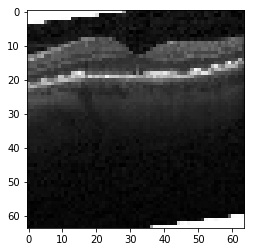

In [61]:
imshow(rgb_data[0][0]);

In [57]:
# img_classes = ['normal', 'cnv', 'dme', 'drusen']
# rgb_img_size = 64
# original_dir = 'Data'

# # keep myself from re-creating this list unnecessarily 
# try:
#     rgb_data = rgb_data
#     print('Larger, colored data already exists in this dimension')
#     print(len(rgb_data))
# except NameError: 
#     rgb_data = None
#     print('Re-loading images')

# if rgb_data is None:
#     rgb_data = []
#     for img_class in img_classes:

#         path = os.path.join(original_dir, img_class)
#         # assign numeric value to class labels
#         class_num = img_classes.index(img_class)

#         for img in os.listdir(path):

#             file = os.path.join(path, img)
#             # if-else keeps .DS_store from throwing an error
#             if file.endswith('.jpeg'):
#                 img_array = cv2.imread(os.path.join(path, img))
#                 # resize images to (64,64)
#                 resize_array = cv2.resize(img_array, (rgb_img_size, rgb_img_size))
#                 # create new data list of resized images with their class labels
#                 rgb_data.append([resize_array, class_num])
#             else:
#                 print(file)

Re-loading images
Data/normal/.DS_Store


In [59]:
len(rgb_data)

83605

In [60]:
# np.save('./Data/larger_rgb_img_array', rgb_data)

In [62]:
# WHY IS IT GRAYSCALE WHEN I WANT IT TO BE COLOR, AND IT WAS COLOR WHEN I WANTED IT TO BE GRAYSCALE?!?!?!

In [63]:
rgb_data = np.array(rgb_data)

In [65]:
X = []
y = []

for feature, label in rgb_data:
    X.append(feature/255)
    y.append(label)

In [68]:
X = np.array(X).reshape(-1, rgb_img_size, rgb_img_size, 3)
y = to_categorical(y, num_classes=4)

In [69]:
print(X.shape)
print(y.shape)

(83605, 64, 64, 3)
(83605, 4)


In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=19, test_size=0.2)

In [71]:
cnn_base = VGG19(weights='imagenet',
                  include_top=False,
                  input_shape=(64, 64, 3))

In [72]:
cnn_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
__________

In [73]:
model = Sequential()
model.add(cnn_base)
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(4, activation='softmax'))

In [74]:
for layer in model.layers:
    print(layer.name, layer.trainable)

vgg19 True
flatten_4 True
dense_7 True
dense_8 True


In [75]:
# freeze cnn base and recheck

cnn_base.trainable = False
for layer in model.layers:
    print(layer.name, layer.trainable)

vgg19 False
flatten_4 True
dense_7 True
dense_8 True


In [76]:
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [77]:
# start = datetime.datetime.now()

# model.fit(X_train, y_train, epochs=10, validation_split=0.2)
# elapsed = datetime.datetime.now() - start
# print(f'Time elapsed: {elapsed}')

Train on 53507 samples, validate on 13377 samples
Epoch 1/10
53507/53507 [==============================] - 1617s 30ms/step - loss: 0.8691 - acc: 0.6603 - val_loss: 0.7929 - val_acc: 0.6966
Epoch 2/10
53507/53507 [==============================] - 1507s 28ms/step - loss: 0.7538 - acc: 0.7102 - val_loss: 0.8290 - val_acc: 0.6850
Epoch 3/10
53507/53507 [==============================] - 1453s 27ms/step - loss: 0.7128 - acc: 0.7264 - val_loss: 0.7220 - val_acc: 0.7197
Epoch 4/10
53507/53507 [==============================] - 1433s 27ms/step - loss: 0.6874 - acc: 0.7384 - val_loss: 0.7191 - val_acc: 0.7265
Epoch 5/10
53507/53507 [==============================] - 1508s 28ms/step - loss: 0.6709 - acc: 0.7432 - val_loss: 0.6981 - val_acc: 0.7319
Epoch 6/10
53507/53507 [==============================] - 1491s 28ms/step - loss: 0.6559 - acc: 0.7494 - val_loss: 0.7129 - val_acc: 0.7297
Epoch 7/10
53507/53507 [==============================] - 1528s 29ms/step - loss: 0.6442 - acc: 0.7544 - val_l

In [78]:
# this model performs significantly worse than the previous model and not just because it trained for only 10 epochs
# the previous model already had a training accuracy of above 90% at 10 epochs and a validation accuracy of 86%
# though the training and val acc for this model are almost the same, indicating goodness of fit

In [ ]:
# after 10 epochs, this model built on vgg19 had a training loss of 61%, training acc of 77%
# val_loss of 65%, val_acc of 75%

In [83]:
# model.save('Models/vgg19_10_epochs.h5')